<a href="https://colab.research.google.com/github/NuttakitDW/kbtg_data/blob/master/version7_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [213]:
#version 4
data = pd.read_csv('https://raw.githubusercontent.com/NuttakitDW/kbtg_data/master/train_data_v4.csv')
test_X = pd.read_csv('https://raw.githubusercontent.com/NuttakitDW/kbtg_data/master/test_data_v4.csv')
data.head()

,id,gender,ocp_cd,age,income,kp_txn_count,kp_txn_amt,cd_ex,cc_month_mean,kp_month_mean
0,1,2,9.0,5,20000,2.0,3500.0,44700.0,11175.0,3.500000e+03
1,2,2,3.0,4,106000,104.0,210000.0,65200.0,14385.0,3.500000e+04
2,3,2,1.0,3,29000,70.0,139700.0,0.0,0.0,2.328333e+04
3,4,2,3.0,5,61000,315.0,6076100.0,770000.0,500000.0,1.012683e+06
4,5,2,9.0,4,18000,0.0,0.0,12000.0,6000.0,0.000000e+00


In [158]:
data['overall'] = data['kp_txn_amt'] + data['cd_ex']
data.head()

,id,gender,ocp_cd,age,income,kp_txn_count,kp_txn_amt,cd_ex,cc_month_mean,kp_month_mean,overall
0,1,2,9.0,5,20000,2.0,3500.0,44700.0,11175.0,3.500000e+03,48200.0
1,2,2,3.0,4,106000,104.0,210000.0,65200.0,14385.0,3.500000e+04,275200.0
2,3,2,1.0,3,29000,70.0,139700.0,0.0,0.0,2.328333e+04,139700.0
3,4,2,3.0,5,61000,315.0,6076100.0,770000.0,500000.0,1.012683e+06,6846100.0
4,5,2,9.0,4,18000,0.0,0.0,12000.0,6000.0,0.000000e+00,12000.0


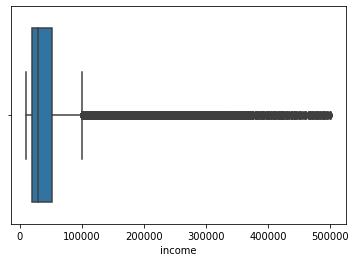

In [159]:
import seaborn as sns
sns.boxplot(x=data['income'])

In [0]:
test_X['overall'] = test_X['kp_txn_amt'] + test_X['cd_ex']

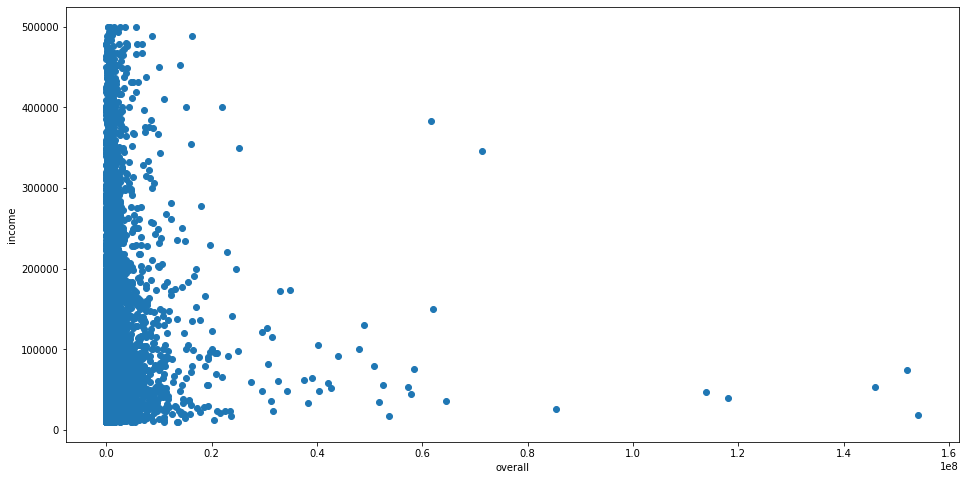

In [161]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['overall'], data['income'])
ax.set_xlabel('overall')
ax.set_ylabel('income')
plt.show()

In [0]:
data_im = data.copy()

In [0]:
#remove outlier by remove data that have overall > 0.6e8 & income > 3e5
indexNames = data_im[((data['income'] > 3e5) & (data['overall'] > 0.4e8))].index
data_im.drop(indexNames , inplace=True)

indexNames2 = data_im[data['overall'] > 0.8e8].index
data_im.drop(indexNames2 , inplace=True)

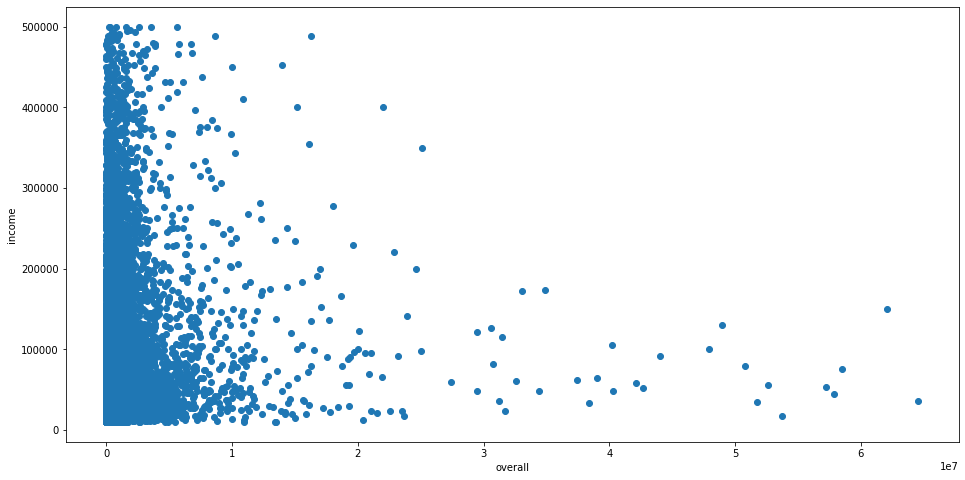

In [165]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data_im['overall'], data_im['income'])
ax.set_xlabel('overall')
ax.set_ylabel('income')
plt.show()

In [0]:
y = data.income
X = data.drop(['income'], axis=1)
feature = ['ocp_cd', 'age', 'cd_ex', 'kp_txn_amt', 'kp_txn_count', 'gender', 'cc_month_mean', 'kp_month_mean', 'overall']
X = X[feature]

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

categorical_cols = [cname for cname in ['ocp_cd', 'age', 'gender']]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full.copy()
X_valid = X_valid_full.copy()

In [0]:
y_im = data_im.income
X_im = data_im.drop(['income'], axis=1)
feature = ['ocp_cd', 'age', 'cd_ex', 'kp_txn_amt', 'kp_txn_count', 'gender', 'cc_month_mean', 'kp_month_mean', 'overall']
X_im = X_im[feature]

X_train_full2, X_valid_full2, y_train2, y_valid2 = train_test_split(X_im, y_im, train_size=0.8, test_size=0.2, random_state=0)
X_train2 = X_train_full2.copy()
X_valid2 = X_valid_full2.copy()

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [0]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, 
                             learning_rate=0.01, gamma=0.3, max_depth=10, 
                             colsample_bytree=1, subsample=0.7, reg_alpha=0, reg_lambda=3,
                             min_child_weight=7, n_estimators=250
                             )

In [181]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_im, y_im)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 20471.455428808593


MAE: 21557.573957226563


In [177]:
X_im.head()

,ocp_cd,age,cd_ex,kp_txn_amt,kp_txn_count,gender,cc_month_mean,kp_month_mean,overall
0,9.0,5,44700.0,3500.0,2.0,2,11175.0,3.500000e+03,48200.0
1,3.0,4,65200.0,210000.0,104.0,2,14385.0,3.500000e+04,275200.0
2,1.0,3,0.0,139700.0,70.0,2,0.0,2.328333e+04,139700.0
3,3.0,5,770000.0,6076100.0,315.0,2,500000.0,1.012683e+06,6846100.0
4,9.0,4,12000.0,0.0,0.0,2,6000.0,0.000000e+00,12000.0


Learning Rate:  0.01
Gamma:  0.3
Max Depth:  10
Subsample:  0.7
Max Features at Split:  1.0
Alpha:  0
Lamda:  3
Minimum Sum of the Instance Weight Hessian to Make a Child:  7
Number of Trees:  250



In [178]:
my_pipeline.fit(X_im, y_im)
res = my_pipeline.predict(test_X[feature])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:58:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
from google.colab import files

output = pd.DataFrame({'id': test_X['id'],
                       'income': res})


output.to_csv('submission6.csv', index=False)
files.download('submission6.csv')

In [189]:
test_X['income'] = res
test_X.head()

,id,gender,ocp_cd,age,income,kp_txn_count,kp_txn_amt,cd_ex,cc_month_mean,kp_month_mean,overall
0,50001,1,9.0,3,28712.062500,28.0,64600.0,31800.0,10600.000000,10766.666667,96400.0
1,50002,1,9.0,4,25289.587891,131.0,93700.0,5900.0,2950.000000,15616.666667,99600.0
2,50003,1,3.0,4,34705.054688,83.0,202500.0,0.0,0.000000,33750.000000,202500.0
3,50004,2,3.0,4,22734.449219,20.0,11000.0,7200.0,1440.000000,1833.333333,18200.0
4,50005,1,3.0,4,33342.300781,67.0,195500.0,14800.0,4933.333333,32583.333333,210300.0


In [190]:
big = pd.concat([data, test_X])
big.tail()

,id,gender,ocp_cd,age,income,kp_txn_count,kp_txn_amt,cd_ex,cc_month_mean,kp_month_mean,overall
14995,64996,2,3.0,2,21169.443359,20.0,41200.0,0.0,0.0,8240.000000,41200.0
14996,64997,2,3.0,2,26983.265625,76.0,201200.0,2100.0,2100.0,33533.333333,203300.0
14997,64998,1,9.0,3,29070.416016,92.0,162000.0,0.0,0.0,27000.000000,162000.0
14998,64999,2,3.0,3,41796.187500,106.0,494800.0,23500.0,5875.0,82466.666667,518300.0
14999,65000,2,9.0,4,22074.230469,0.0,0.0,6000.0,3000.0,0.000000,6000.0


In [0]:
big_im = big.copy()

In [0]:
#remove outlier by remove data that have overall > 0.4e8 & income > 3e5
indexNames = big_im[((big['income'] > 3e5) & (big_im['overall'] > 0.4e8))].index
big_im.drop(indexNames , inplace=True)

indexNames2 = big_im[big_im['overall'] > 0.7e8].index
big_im.drop(indexNames2 , inplace=True)

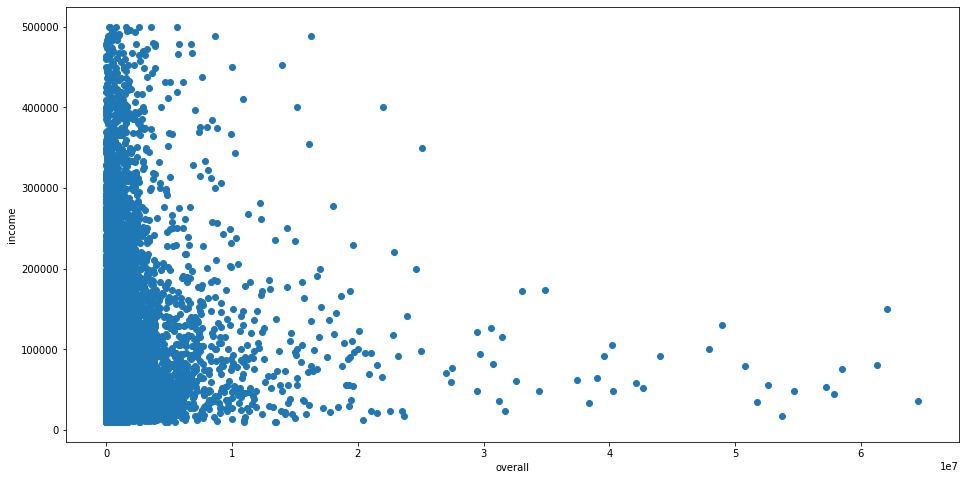

In [196]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(big_im['overall'], big_im['income'])
ax.set_xlabel('overall')
ax.set_ylabel('income')
plt.show()

In [0]:
#remove outlier by remove data that have age == 2 & income > 3e5
indexNames = big_im[((big['income'] > 3e5) & (big_im['age'] > 0.4e8))].index
big_im.drop(indexNames , inplace=True)

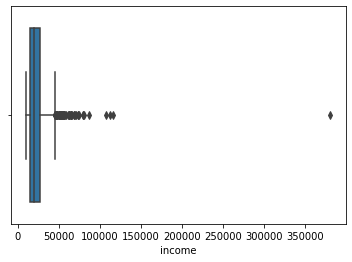

In [208]:
sns.boxplot(x=big_im[big_im['age'] == 2]['income'])

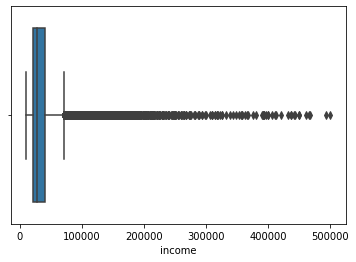

In [209]:
sns.boxplot(x=big_im[big_im['age'] == 3]['income'])

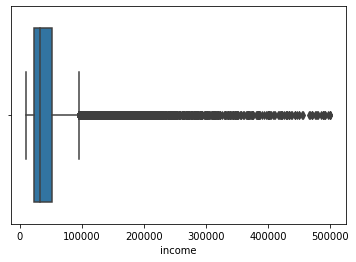

In [210]:
sns.boxplot(x=big_im[big_im['age'] == 4]['income'])

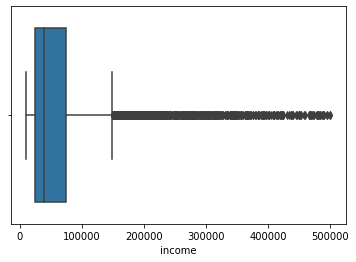

In [211]:
sns.boxplot(x=big_im[big_im['age'] == 5]['income'])

In [0]:
y = big.income
X = big.drop(['income'], axis=1)
feature = ['ocp_cd', 'age', 'cd_ex', 'kp_txn_amt', 'kp_txn_count', 'gender', 'cc_month_mean', 'kp_month_mean', 'overall']
X = X[feature]

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

categorical_cols = [cname for cname in ['ocp_cd', 'age', 'gender']]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full.copy()
X_valid = X_valid_full.copy()

In [0]:
y_im = big_im.income
X_im = big_im.drop(['income'], axis=1)
feature = ['ocp_cd', 'age', 'cd_ex', 'kp_txn_amt', 'kp_txn_count', 'gender', 'cc_month_mean', 'kp_month_mean', 'overall']
X_im = X_im[feature]

X_train_full3, X_valid_full3, y_train3, y_valid3 = train_test_split(X_im, y_im, train_size=0.8, test_size=0.2, random_state=0)
X_train3 = X_train_full2.copy()
X_valid3 = X_valid_full2.copy()

In [200]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train3, y_train3)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:19:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 17146.178474083532


In [201]:
my_pipeline.fit(X_im, y_im)
res = my_pipeline.predict(test_X[feature])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:21:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
from google.colab import files

output = pd.DataFrame({'id': test_X['id'],
                       'income': res})


output.to_csv('submission7.csv', index=False)
files.download('submission7.csv')